In [1]:
import torch 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class NeuralNetwork(torch.nn.Module):

    def __init__(self, n_inputs: int, n_layers: int, n_neurons: int, n_output: int, act):
        super().__init__()

        self.n_inputs = n_inputs 
        self.n_layers = n_layers
        self.n_neurons = n_neurons

        layers = []

        layers.append( torch.nn.Linear(n_inputs, n_neurons))
        for i in range(n_layers): layers.extend( [torch.nn.Linear(n_neurons,n_neurons), act])
        layers.append(torch.nn.Linear(n_neurons, n_output))

        self.network = torch.nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x).squeeze() 

### Problema: Equação de Poisson com condição de contorno de Dirichlet\n

O problema proposto é dado por:

$$
\bigtriangleup u = \pi^2 \sin(\pi x), \hspace{0.5cm} x \in [-1, 1]
$$

onde as condições de contorno são dadas por $u(-1) = u(1) = 0$.

A solução exata do problema é $u(x) = \sin(\pi x)$

In [3]:
MODEL = NeuralNetwork(1, 3, 60, 1, torch.nn.Tanh())
MODEL = torch.jit.script(MODEL)

X = torch.FloatTensor(100).uniform_(-1, 1).requires_grad_()
X = X.unsqueeze(-1)

In [4]:
# DEFINIÇÃO DA EQUAÇÃO RESIDUAL
def f(x): 
    return torch.pi**2 * torch.sin(torch.pi * x)

def residuo(model, x):

    u = model(x)
    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0]

    return u_xx + f(x)

def loss_fn(model):

    # PERDA DA EQUAÇÃO RESIDUAL
    out_res = residuo(model, X)
    l_res = torch.mean(torch.square(out_res))

    # PERDA PARA OS VALORES DE CONTORNO
    out_cont1 = model(torch.tensor([-1.]))
    out_cont2 = model(torch.tensor([1.]))
    l_cont1 = torch.mean(torch.square(out_cont1))
    l_cont2 = torch.mean(torch.square(out_cont2))

    # PERDA TOTAL
    loss = l_res + l_cont1 + l_cont2
    return loss 

# PARÂMETROS DO TREINAMENTO 
optmizer = torch.optim.Adam(MODEL.parameters(), lr= 1e-3)

# LOOP DE TREINAMENTO
loss_history = []
for ep in range(5000):

    optmizer.zero_grad()

    loss = loss_fn(MODEL)
    loss_history.append(loss.item())

    with torch.autograd.no_grad():
        if ep % 1000 == 0:
            print(f'Epochs: {ep} Loss: {loss.item()}')

    loss.backward(retain_graph = True)
    optmizer.step()

Epochs: 0 Loss: 51.055179595947266
Epochs: 1000 Loss: 0.0008155811228789389
Epochs: 2000 Loss: 0.00047737901331856847
Epochs: 3000 Loss: 0.00030719401547685266
Epochs: 4000 Loss: 0.00018127774819731712


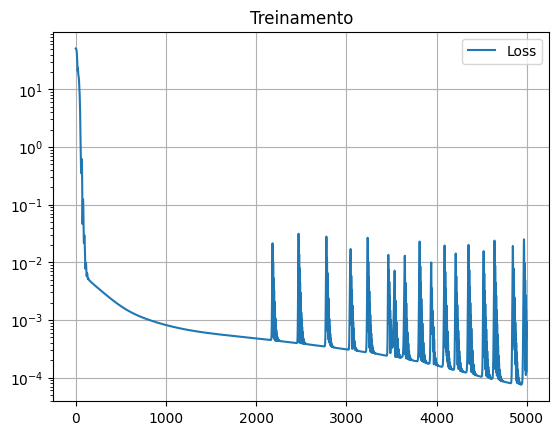

In [5]:
plt.plot(loss_history, label = 'Loss')
plt.title('Treinamento')
plt.yscale('log')
plt.grid()
plt.legend()
plt.show()

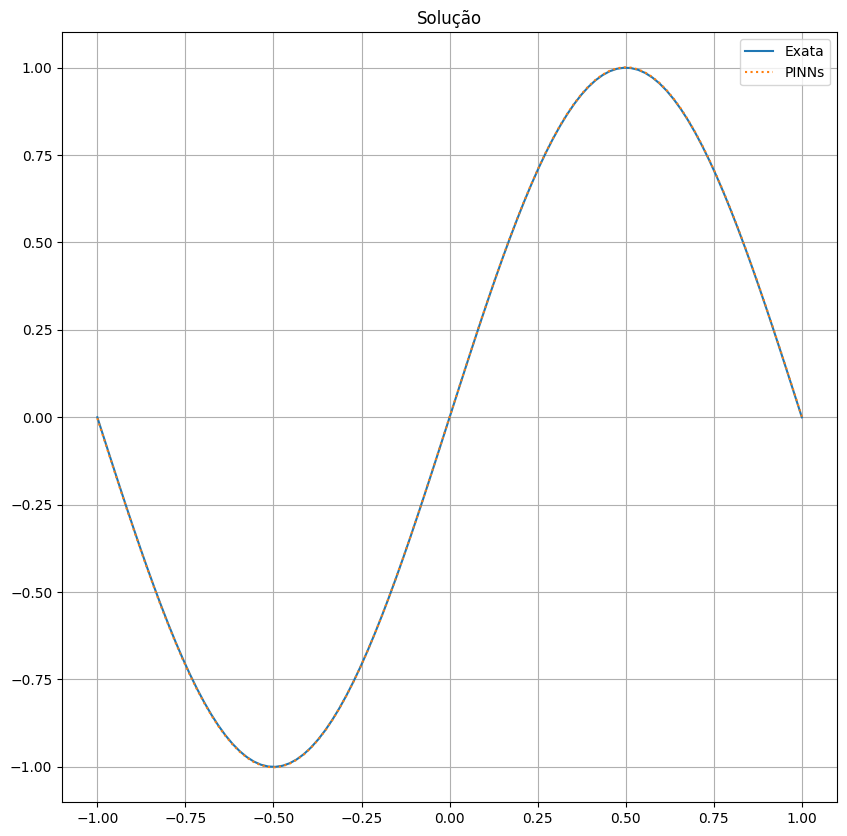

In [6]:
X = torch.linspace(-1, 1, 100).unsqueeze(-1)
EXATA = np.sin(np.pi * X)
PRED = MODEL(X)

PRED = PRED.detach().numpy()

plt.figure(figsize=(10, 10))
plt.plot(X, EXATA, label = 'Exata')
plt.plot(X, PRED, label = 'PINNs', linestyle = 'dotted')
plt.title('Solução')
plt.grid()
plt.legend()
plt.show()